В задаче необходимо построить условный состязательный автокодировщик, принимающий метку класса только на вход декодера ("нечестный" вариант). После обучения модели требуется оценить качество латентного представления, для чего нужно проверить его на содержание признаков, подходящих для классификации входных данных.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from utils import mnist, plot_graphs, plot_mnist, to_onehot

%matplotlib inline

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [0]:
mnist_0_1 = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
# Задание переменных.
param_input_shape = 28*28
param_layers_size = (1024, 1024)
param_ld_size = 2
param_num_classes = 10
param_ae_loss_fn = F.binary_cross_entropy_with_logits
param_batch_size = 250

train_loader, valid_loader, test_loader = mnist(batch_size=param_batch_size, valid=10000, transform=mnist_0_1)

batch_zeros = torch.zeros((param_batch_size, 1)).to(device)
batch_ones = torch.ones((param_batch_size, 1)).to(device)
# Многомерное нормальное распределение (для истинных сэмплов).
distribution = torch.distributions.MultivariateNormal(torch.zeros(param_ld_size), torch.eye(param_ld_size))

fixed_z = distribution.sample((10, )).repeat((1,10)).view(-1, param_ld_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

In [0]:
class Encoder(nn.Module):    
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(param_input_shape, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.z = nn.Linear(param_layers_size[1], param_ld_size)        
    
    def forward(self, x):
        x = x.view(-1, param_input_shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        z = self.z(x)        
        return z

class Decoder(nn.Module):
    # Восстанавливает изображение из z и метки класса.
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(param_ld_size+10, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(param_layers_size[1], param_input_shape)
    
    def forward(self, x, target):        
        x = torch.cat([x, target], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))        
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(param_ld_size, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(param_layers_size[1], 1)

    def forward(self, x):
        x = torch.relu(self.do1(self.fc1(x)))
        x = torch.relu(self.do2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [0]:
E = Encoder()
# Оптимизатор для кодировщика.
E_opt = optim.Adam(E.parameters(), lr=1e-4)
E.to(device)
D = Decoder()
# Оптимизатор декодера.
D_opt = optim.Adam(D.parameters(), lr=1e-4)
D.to(device)
DC = Discriminator()
# Оптимизатор дискриминатора.
DC_opt = optim.Adam(DC.parameters(), lr=1e-3)
DC.to(device)

train_log = {'AE': [], 'E': [], "DC": []}
test_log = {'AE': [], 'E': [], "DC": []}

In [0]:
def train(epoch, E, D, DC, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):        
        data = data.to(device)
        target = to_onehot(target, 10, device)

        # Обучение дискриминатора.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()
        
        fake_z = DC(E(data))
        true_z = DC(distribution.sample((param_batch_size, )).to(device))
        fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones)

        DC_loss = 0.5*(fake_loss + true_loss)
        DC_loss.backward()
        DC_opt.step()

        # Обучение автокодировщика.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()
        z = E(data)
        recon = D(z, target)
        reconstruction_loss = param_ae_loss_fn(recon, data.view(-1, param_input_shape))

        fake_z = DC(z)
        regularization_loss = F.binary_cross_entropy_with_logits(fake_z, batch_ones)

        AE_loss = reconstruction_loss + regularization_loss

        AE_loss.backward()
        D_opt.step()
        E_opt.step()
        
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'AE: {:.4f}, E: {:.4f}, DC: {:.4f}'.format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
            print(line + losses)

    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'AE: {:.4f}, E: {:.4f}, DC:{:.4f}'.format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
        print(line + losses)
        log['AE'].append(reconstruction_loss.item())
        log['E'].append(regularization_loss.item())
        log['DC'].append(DC_loss.item())

In [0]:
def test(E, D, DC, loader, epoch, log=None):
    test_size = len(loader)
    reconstruction_loss = 0.
    regularization_loss = 0.
    DC_loss = 0.    
    test_loss = {'AE': 0., 'E': 0., "DC": 0}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = to_onehot(target, 10, device)

            z = E(data)
            recon = D(z, target)
            reconstruction_loss += param_ae_loss_fn(recon, data.view(-1, param_input_shape)).item()

            fake_z = DC(z)
            true_z = DC(distribution.sample((param_batch_size, )).to(device))
            fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones).item()
            DC_loss += 0.5*(fake_loss + true_loss)
            
            regularization_loss += F.binary_cross_entropy_with_logits(fake_z, batch_ones).item()            
    
    reconstruction_loss /= test_size
    regularization_loss /= test_size
    DC_loss /= test_size
    
    report = 'Test losses. AE: {:.4f}, E: {:.4f}, DC: {:.4f}\n'.format(reconstruction_loss, regularization_loss, DC_loss)
    print(report)
    if log is not None:
        log['AE'].append(reconstruction_loss)
        log['E'].append(regularization_loss)
        log['DC'].append(DC_loss)

In [37]:
for epoch in range(1, 101):
    E.train()
    D.train()
    DC.train()
    train(epoch, E, D, DC, train_log)
    E.eval()
    D.eval()
    DC.eval()
    test(E, D, DC, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses AE: 0.6935, E: 1.1363, DC: 0.5092
Train Epoch: 1 [25000/50000 (50%)]	Losses AE: 0.2697, E: 2.3874, DC: 0.1918
Train Epoch: 1 [50000/50000 (100%)]	Losses AE: 0.2358, E: 1.0444, DC:0.5791
Test losses. AE: 0.2334, E: 1.0566, DC: 0.5750

Train Epoch: 2 [0/50000 (0%)]	Losses AE: 0.2376, E: 1.0552, DC: 0.5943
Train Epoch: 2 [25000/50000 (50%)]	Losses AE: 0.2198, E: 0.7908, DC: 0.6937
Train Epoch: 2 [50000/50000 (100%)]	Losses AE: 0.2099, E: 0.7762, DC:0.6710
Test losses. AE: 0.2112, E: 0.7618, DC: 0.6876

Train Epoch: 3 [0/50000 (0%)]	Losses AE: 0.2042, E: 0.7832, DC: 0.6910
Train Epoch: 3 [25000/50000 (50%)]	Losses AE: 0.2046, E: 0.6926, DC: 0.6951
Train Epoch: 3 [50000/50000 (100%)]	Losses AE: 0.2022, E: 0.7019, DC:0.6905
Test losses. AE: 0.2009, E: 0.6977, DC: 0.6892

Train Epoch: 4 [0/50000 (0%)]	Losses AE: 0.2013, E: 0.7027, DC: 0.6883
Train Epoch: 4 [25000/50000 (50%)]	Losses AE: 0.1938, E: 0.6662, DC: 0.6817
Train Epoch: 4 [50000/50000 (100%)]	Loss

График ошибок. Кодировщик и дискриминатор сходятся к 0,69 за 20 эпох. Ошибка восстановления перестает снижаться после 60.

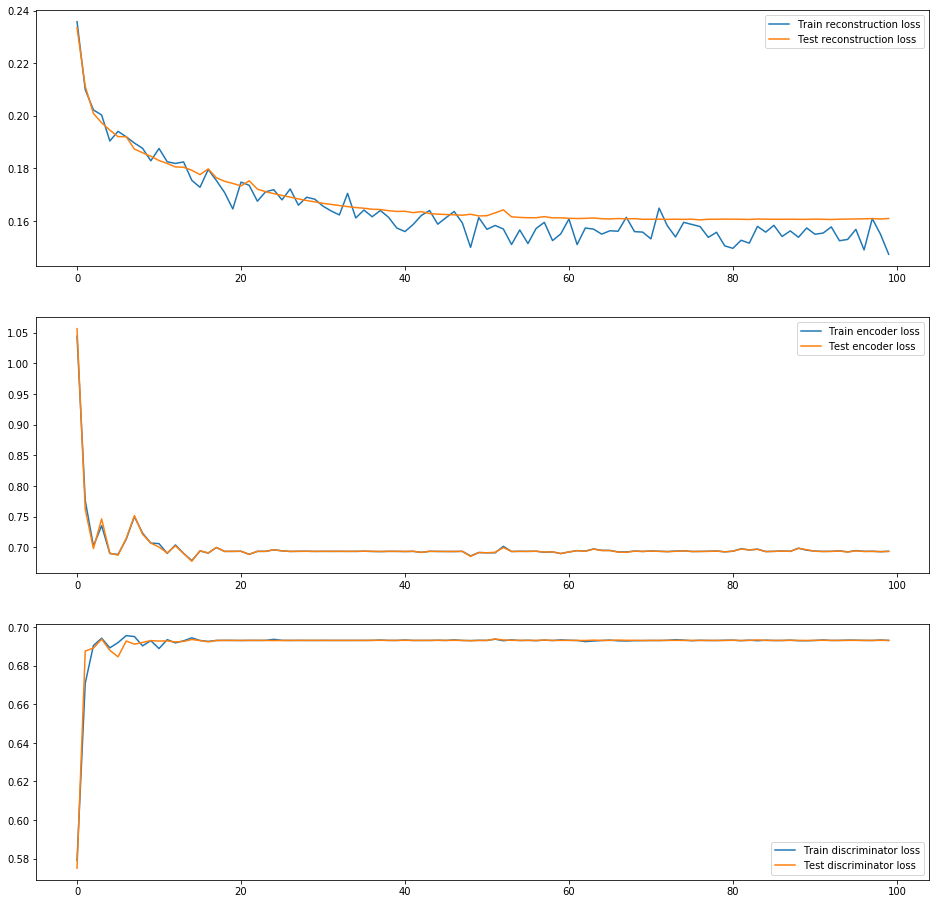

In [38]:
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
plt.plot(train_log["AE"], label="Train reconstruction loss")
plt.plot(test_log["AE"], label="Test reconstruction loss")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(train_log["E"], label="Train encoder loss")
plt.plot(test_log["E"], label="Test encoder loss")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(train_log["DC"], label="Train discriminator loss")
plt.plot(test_log["DC"], label="Test discriminator loss")
plt.legend()
plt.show()

Вывод сгенерированных автокодировщиком изображений по входным данным и по сэмплу нормального распределения.

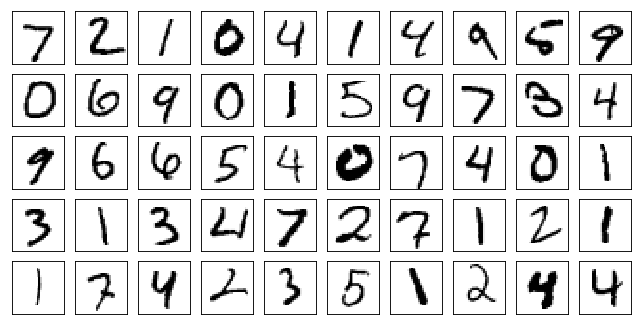

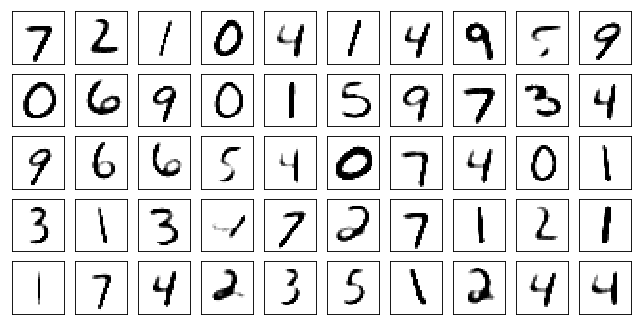

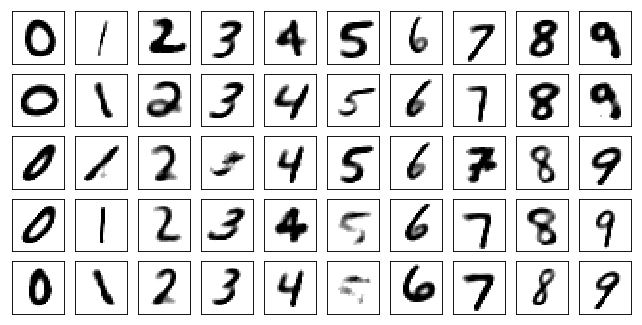

In [58]:
data, target = next(iter(test_loader))
data = data[:50].to(device)
target = to_onehot(target[:50], 10, device)
output = D(E(data), target)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = D(distribution.sample((param_batch_size, ))[:50].to(device), to_onehot(torch.tensor(list(range(10))).repeat((10)), 10)[:50].to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(dec_to_plot, (5, 10))

Отрисовка места некоторых цифр в латентном пространстве.

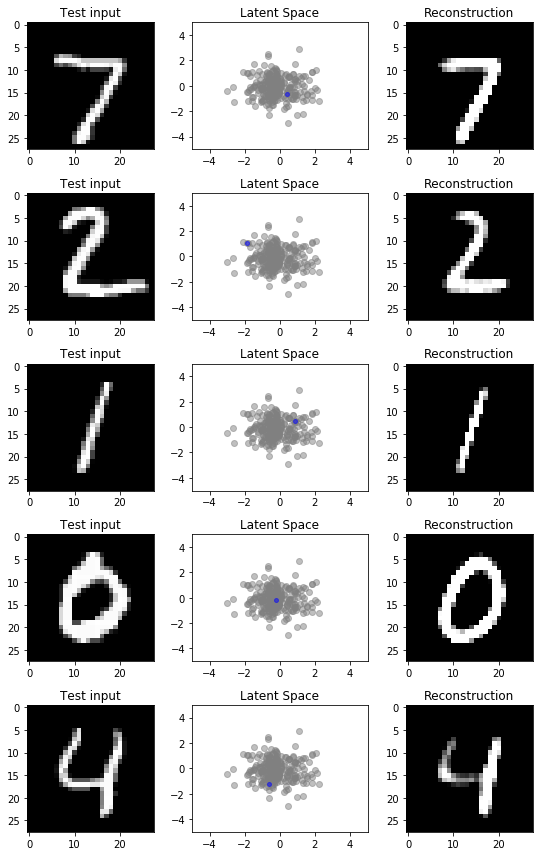

In [42]:
data, target = next(iter(test_loader))
data = data.to(device)
target = to_onehot(target, 10, device)
z = E(data)
output = D(z, target)

plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 3, 3*i + 1)
    plt.imshow(data[i].cpu().reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Test input")
        
    plt.subplot(5, 3, 3*i + 2)
    plt.scatter(z.cpu().detach()[:,0],z.cpu().detach()[:,1], c='gray', alpha=0.5)
    #plt.scatter(m.cpu().detach()[i,0],m.cpu().detach()[i,1], c='green', s=64, alpha=0.5)
    plt.scatter(z.cpu().detach()[i,0],z.cpu().detach()[i,1], c='blue', s=16, alpha=0.5)
       
    plt.xlim((-5,5))
    plt.ylim((-5,5))
    plt.title("Latent Space")
        
    plt.subplot(5, 3, 3*i + 3)
    plt.imshow(output.cpu().detach()[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
    plt.title("Reconstruction")
        
    plt.tight_layout()

Карта скрытого пространства для класса 3. Видно как изменяется стиль, в нижней части много артефактов.

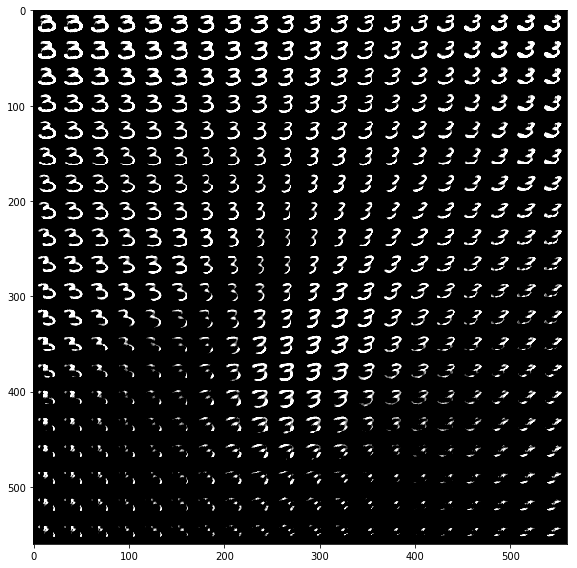

In [54]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        d = np.zeros([1,param_ld_size],dtype='float32')
        z_mu = np.array([[xi, yi]])
        d[0,:2] = z_mu        
        x_mean = D(torch.Tensor(d).to(device), torch.Tensor([[0,0,0,1,0,0,0,0,0,0]]).to(device))
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean.cpu().detach()[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

Вывод зафиксированных в начале сэмплов и меток.

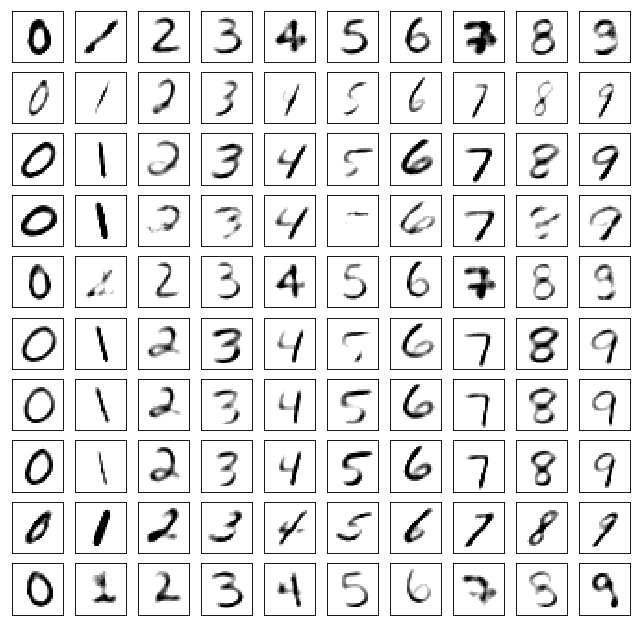

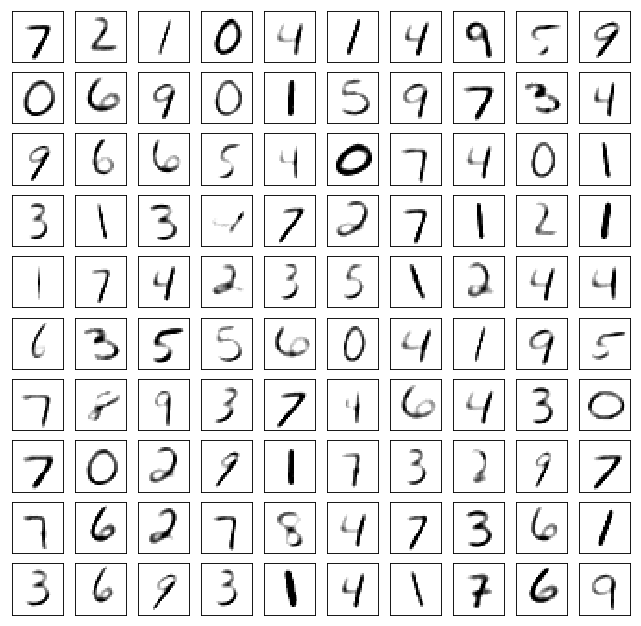

In [62]:
fixed_gen = ((D(fixed_z, fixed_z_label))*0.5).clamp(0, 1).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen, (10, 10))
fixed_reconstruction = ((D(E(fixed_data), fixed_label))*0.5).clamp(0, 1).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction, (10, 10))

Создание классификаторов.

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [0]:
Cla = FullyConnected([2, 256, 512, 256, 10], flatten=True, dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)
Cla_opt = optim.Adam(Cla.parameters(), lr=1e-4)

cla_train_log = {'Cla': []}
cla_test_log = {'Cla': []}

In [0]:
def train_cla(epoch, by_latent=False, log_interval=200):    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        Cla_opt.zero_grad() 
        
        if by_latent:
            latent = E(data)
            output = Cla(latent)
        else:
            output = Cla(data)

        loss = F.cross_entropy(output, target)
        loss.backward()        
        Cla_opt.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [0]:
def test_cla(loss_vector, accuracy_vector, by_latent=False):    
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        if by_latent:
            latent = E(data)
            output = Cla(latent)
        else:
            output = Cla(data)
        val_loss += F.cross_entropy(output, target).data.item()
        pred = output.data.max(1)[1] 
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

Обучение классификатора на исходных данных. За 10 эпох достигается точнось 95%.

In [108]:
Cla = FullyConnected([28*28, 256, 512, 256, 10], flatten=True, dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)
Cla_opt = optim.Adam(Cla.parameters(), lr=1e-4)

lossv, accv = [], []
E.eval()
D.eval()
DC.eval()
for epoch in range(1, 11):    
    Cla.train()
    train_cla(epoch)
    Cla.eval()
    test_cla(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300358

Validation set: Average loss: 0.4519, Accuracy: 8724/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.448696

Validation set: Average loss: 0.3237, Accuracy: 9068/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.336920

Validation set: Average loss: 0.2805, Accuracy: 9187/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.323632

Validation set: Average loss: 0.2514, Accuracy: 9264/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.296561

Validation set: Average loss: 0.2270, Accuracy: 9326/10000 (93%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.252371

Validation set: Average loss: 0.2079, Accuracy: 9379/10000 (94%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.191823

Validation set: Average loss: 0.1922, Accuracy: 9410/10000 (94%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.231440

Validation set: Average loss: 0.1783, Accuracy: 9454/10000 (95%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.253348

Validation set: Average loss: 0.1670, Accuracy: 9483/10000

Графики ошибок и точности.

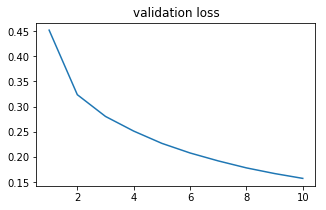

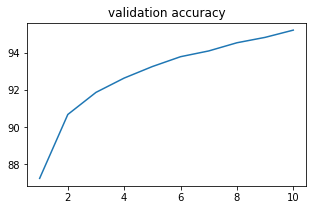

In [109]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,10+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,10+1), accv)
plt.title('validation accuracy');

Обучение классификатора на латентном пространстве. Достигается точность 28%, что выше, чем при случайном угадывании 1 из 10 классов. Можно сделать вывод, что кодировщик сохраняет некоторую долю информации о классе входа.

In [101]:
Cla = FullyConnected([2, 256, 512, 256, 10], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)
Cla_opt = optim.Adam(Cla.parameters(), lr=1e-4)

lossv, accv = [], []
E.eval()
D.eval()
DC.eval()
for epoch in range(1, 101):    
    Cla.train()
    train_cla(epoch, by_latent=True)
    Cla.eval()
    test_cla(lossv, accv, by_latent=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309324

Validation set: Average loss: 2.0168, Accuracy: 2656/10000 (27%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.096264

Validation set: Average loss: 2.0007, Accuracy: 2716/10000 (27%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.964313

Validation set: Average loss: 1.9907, Accuracy: 2752/10000 (28%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.038077

Validation set: Average loss: 1.9846, Accuracy: 2758/10000 (28%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.030788

Validation set: Average loss: 1.9805, Accuracy: 2782/10000 (28%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.039679

Validation set: Average loss: 1.9751, Accuracy: 2753/10000 (28%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.003125

Validation set: Average loss: 1.9756, Accuracy: 2770/10000 (28%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.047253

Validation set: Average loss: 1.9717, Accuracy: 2768/10000 (28%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.944461

Validation set: Average loss: 1.9719, Accuracy: 2777/10000

Графики ошибок и точности.

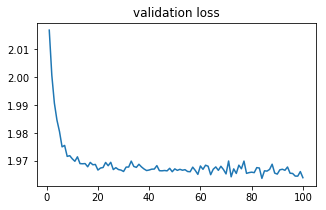

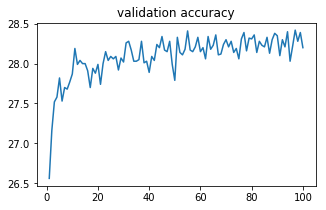

In [103]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,100+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,100+1), accv)
plt.title('validation accuracy');